In [5]:
import os
import numpy as np
import scipy.io as sio #for loading .mat files
import matplotlib.pyplot as plt

# special line of code just for jupyter inline plotting
%matplotlib inline

import seaborn as sns 

# from tqdm import tqdm as tqdm

# from src.utils.signal import rolling_window, bin_dataset, condense_spectrogram,gen_freq_bins,pspec,periodogram

ImportError: cannot import name 'rolling_window'

In [13]:
from tqdm import tqdm as tqdm
import mtspec.multitaper as mtm

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def bin_dataset(dataset,window_s=30,fs=1024,downsample_factor=1):
    total_seconds = len(dataset)//fs
    output = []
    total_slices = total_seconds//window_s
    for i in np.arange(total_slices):
        slc = slice(window_s*fs*i,window_s*fs*(i+1),downsample_factor)
        output.append(dataset[slc].tolist())
    return np.array(output)

def pspec(data,samp_freq=1,df=1):
    # data.shape -> (epoch, window_length)
    win = int(data.shape[1])
    tw = df*win/samp_freq/2
    
    # L is a rough estimate of number of tapers needed
    L = int(2*tw)-1

    tapers,lamb,theta = mtm.dpss(win,tw,L)
    tapers = np.swapaxes(tapers,0,1)
    fft_split_data = []
    freqs = np.fft.fftfreq(win,d=1/samp_freq)[1:win//2]
    
    for i in tqdm(np.arange(data.shape[0])):
        # Copy the window L, times
        # rep_data -> 
        rep_data = np.matlib.repmat(data[i],L,1)
        
        # Elementwise multiplication of taper
        split_data = np.multiply(rep_data,tapers)
        
        # fft of the tapered data
        fft_data = np.fft.fft(split_data)[:,1:win//2]*2
        
        # Take the abs and square the frequency spectra
        fft_split_data.append(np.abs(fft_data)**2)

    # fft_split_data.shape = [num_epochs, num_tapers, freq_power]
    # Average over the tapers to get [num_epochs,mean_freq_power]
    mtspec_data = np.array(fft_split_data).mean(axis=1)
    
    mtpspec = mtspec_data.swapaxes(0,1)
    
    return (mtpspec,freqs,tapers)

def periodogram(data,samp_freq=1):
    win = int(data.shape[1])
    freqs = np.fft.fftfreq(win,d=1/samp_freq)[1:win//2]
    fft_split_data = []
    for i in tqdm(np.arange(data.shape[0])):
        epoch_dat = data[i]*(1/np.sqrt(win))
        fft_data = np.fft.fft(epoch_dat)[1:win//2]*2
        fft_split_data.append(np.abs(fft_data)**2)
    
    spx_data = np.swapaxes(np.array(fft_split_data),0,1)

    return (spx_data,freqs)

def condense_spectrogram(spec_data,freq_bins):
    num_freq_bins = len(freq_bins)
    num_epochs = spec_data.shape[1]
    condensed_spxgm = np.empty((num_freq_bins,num_epochs))
    for i,idxs in enumerate(freq_bins):
        condensed_spxgm[i,:] = spec_data[idxs,:].sum(axis=0)
    
    return condensed_spxgm

def gen_freq_bins(freqs,freq_ranges):
    # Parameters
    # freq_ranges:  list
    #     List of tuples of frequency range (inclusive). e.x. (0,3)
    freq_index_bins = [(f_start<freqs) & (freqs<f_stop) for f_start, f_stop in freq_ranges]
    
    return freq_index_bins

'/home/elijahc/dev/sleep_ann/notebooks'

In [2]:
# [2,2,3,3,1,1,2,3,2,1]
pt_id = 2
pairs = (1,2)
data_dir = '/home/elijahc/data/uminn/raw/py_export'
fp = os.path.join(data_dir,'pt'+str(pt_id)+'_raw_LFP.mat')
print(fp)
lfp = sio.loadmat(fp)['data'][0][0][0]

/home/elijahc/data/uminn/raw/py_export/pt2_raw_LFP.mat


In [3]:
ds_fx=2
lfp_bipolar = lfp[:,pairs[0]]-lfp[:,pairs[1]]
# window_in_seconds*sampling_frequency*0.5
# step = 30*1024//4
# lfp_bipolar_w_overlap = rolling_window(lfp_bipolar,window=30*1024)[::step,:]
# print(lfp_bipolar_w_overlap.shape)
binned_lfp = bin_dataset(lfp_bipolar,downsample_factor=ds_fx)
fs = 1024//ds_fx
print(binned_lfp.shape)

print(fs)

(1149, 15360)
512


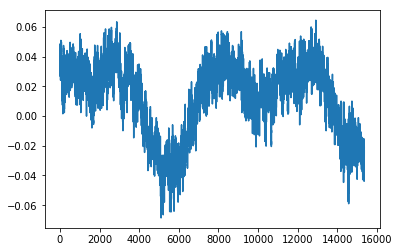

In [4]:
plt.plot(binned_lfp[6])

In [5]:
df = 0.25
N = binned_lfp.shape[1]//fs
tw = df*N/2
L = int(2*tw)-1
print('Stationary Window (s): ',N)
print('Sampling Frequency (Hz): ',fs)
print('tw: ',tw)
print('Number of Tapers: ',L)

Stationary Window (s):  30
Sampling Frequency (Hz):  512
tw:  3.75
Number of Tapers:  6


In [6]:
spec, freqs, tapers = pspec(binned_lfp,samp_freq=fs,df=df)
spx_periogram, perio_freqs = periodogram(binned_lfp,samp_freq=fs)

100%|██████████| 1149/1149 [00:00<00:00, 1530.93it/s]


In [7]:
print(spec.shape)
print(spx_periogram.shape)

(7679, 1149)
(7679, 1149)


In [8]:
freqs_1Hz = [(f,f+1) for f in np.arange(freqs.max())]

mt_freq_bins = gen_freq_bins(freqs, freq_ranges=freqs_1Hz)
c_mtspx = condense_spectrogram(spec,mt_freq_bins)
mt_spec_p = 20*np.log10(c_mtspx)

perio_freq_bins = gen_freq_bins(perio_freqs,freq_ranges=freqs_1Hz)
c_spx_periogram = condense_spectrogram(spx_periogram,perio_freq_bins)
spx_perio_p = 20*np.log10(c_spx_periogram)

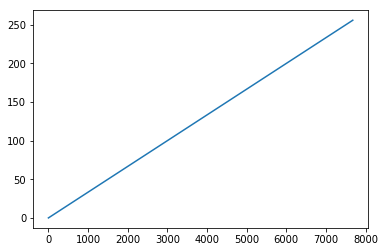

In [9]:
plt.plot(freqs)

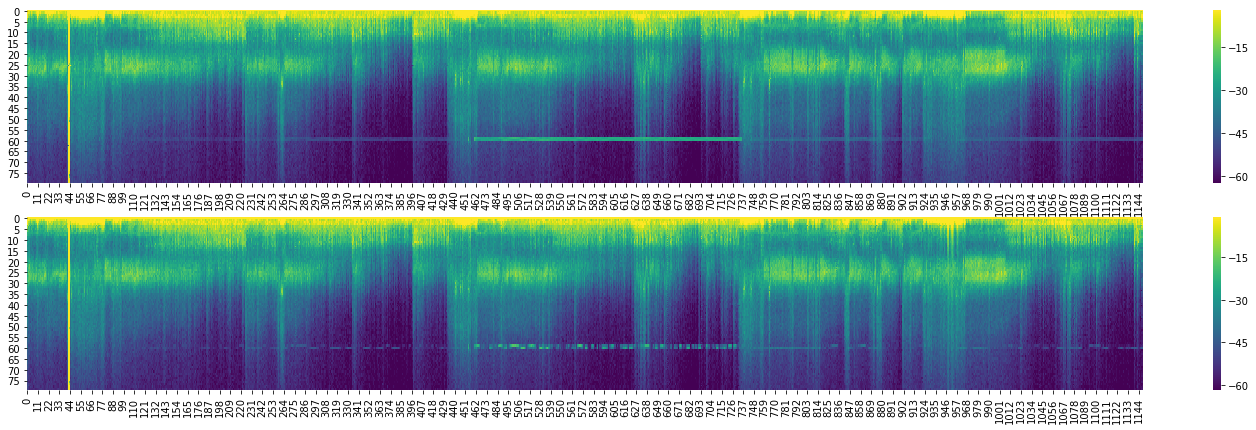

In [10]:
fig,ax = plt.subplots(2,1, figsize=(25,7),sharey=True)
# plt.yticks(np.arange(3839),freqs)
sns.heatmap(mt_spec_p[:80],
            robust=True,
#             vmax=5,
            ax=ax[0],
            cmap='viridis')
sns.heatmap(spx_perio_p[:80],
#             vmax=5,
            robust=True,
            ax=ax[1],
            cmap='viridis')

In [11]:
save_path = './spectrograms/mt_spec_pt'+str(pt_id)+'.npy'
print(save_path)
np.save(save_path,mt_spec_p)

./spectrograms/mt_spec_pt2.npy


FileNotFoundError: [Errno 2] No such file or directory: './spectrograms/mt_spec_pt2.npy'